# Project 4
### Introduction

In this project, we explore two different types of data analysis problems using Python. 

In Topic 1, we work with sky maps of the Milky Way and investigate how different pixel encodings affect the clustering of astronomical images using K-means. We study how brightness, raw RGB values, and colour-normalised features change the resulting clusters.

In Topic 2, we shift to supervised learning and analyse real-world epidemic data from the Ebola outbreak in West Africa. Here, we use different regression models to model the growth of reported cases and compare how well different models fits the data for different countries.

Overall, the project allows us to apply both unsupervised and supervised learning methods, interpret the results, and reflect on the limitations of these approaches.
Group members:  **Andreas Turøy Krag** and **Silas Handeland Hamran**

This notebook addresses topic 1 and 2 in Project 4. The actual implementation is contained in
`milkyway_clustering.py`; the notebook is mainly used to:document the different tasks, call functions from the module, and display and briefly discuss the results.

A stable internet connection is necessary to run this notebook

# Topic 1  
## Unsupervised learning: Clustering the Milky Way



## Task 0 – Install mw_plot

The first step is to install the `mw_plot` package (from `milkyway-plot.readthedocs.io`),
which is used to draw views of the Milky Way.  
This is done once in the environment where the notebook is executed.
It also imports necessary librares and features.


In [1]:
# Necessary imports in the notebook
%matplotlib inline

# To install mw_plot:
!python -m pip install mw_plot

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.units as u

from milkyway_clustering import *

## Task 1 – Reproduce a Milky Way sky map using MWSkyMap

Here we create a first sky map using the helper function create_mw_skymap.
The default configuration uses the M31 centre and the same background
survey as in the example notebook provided with the project.


The coordinates are: 10.6847083 41.26875


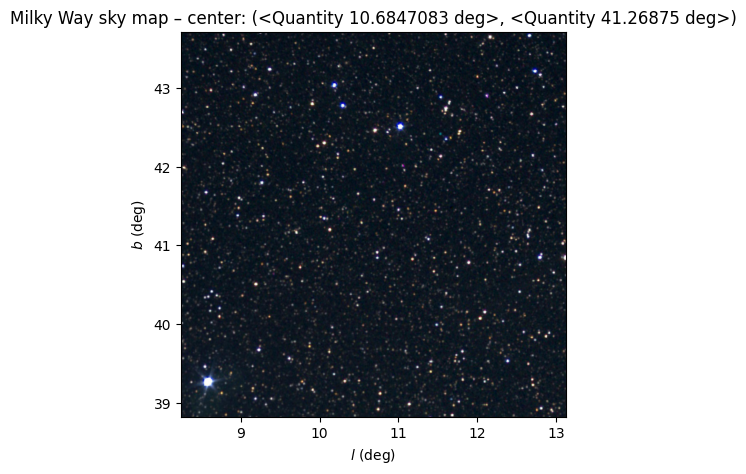

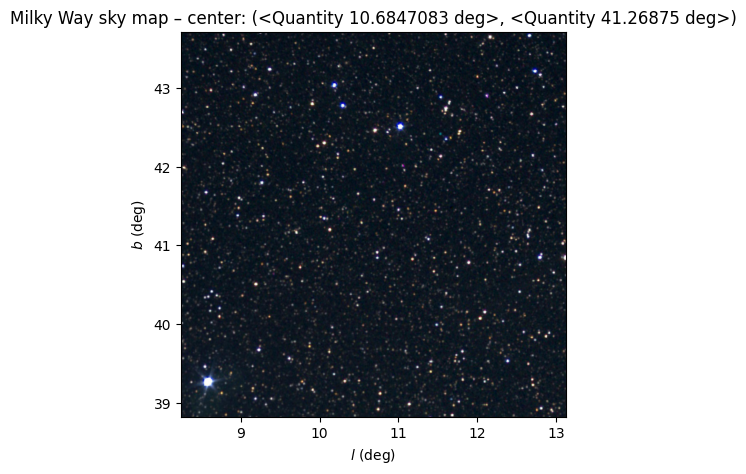

In [2]:
## Task 1 – Reproduce a Milky Way sky map using MWSkyMap

from astropy import units as u
from astropy.coordinates import SkyCoord
# Using RA/Dec for M31 in degrees (needs units for MWSkyMap)
m31 = SkyCoord.from_name("M31")
print("The coordinates are:", m31.ra.deg, m31.dec.deg)

config_t1 = SkyMapConfig(
    center=(m31.ra.deg*u.deg, m31.dec.deg*u.deg),   # M31 coords with units
    radius_arcsec=(8800, 8800)                 # same radius as example
)

# Create the sky map (function comes from milkyway_clustering.py)
fig_t1, ax_t1, mw_t1 = create_mw_skymap(config_t1)

# Show the figure
fig_t1


## Task 2 – Explore different centres and radii

We now generate several sky maps for different centres and/or different
radii. This will later provide several candidate images for clustering.

I got a "Connection error" when using `SkyCoord.from_name()` inside the `milkyway_clustering.py` file, so that's why that function is called outside the loop. Might have been random but it kept occuring. 
The last radius is lower since Polaris is already 89.26410897 deg and adding more would lead to it being more than 90 deg. 

Coordinates: M31 10.6847083 41.26875
Coordinates: Sgr A* 266.416816625 -29.007824972
Coordinates: Polaris 37.95456067 89.26410897


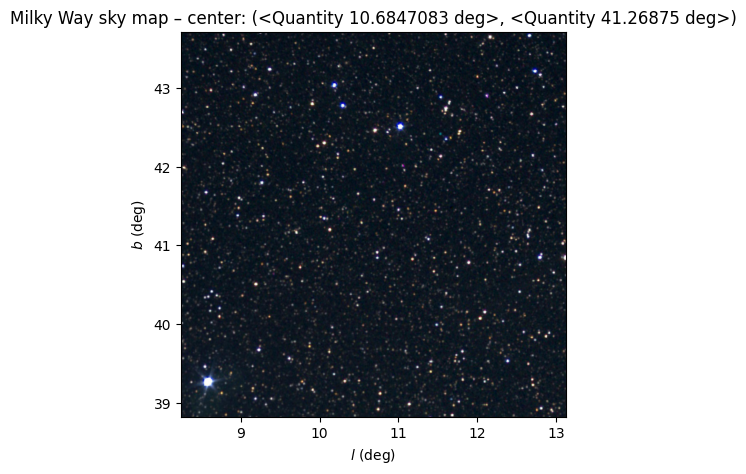

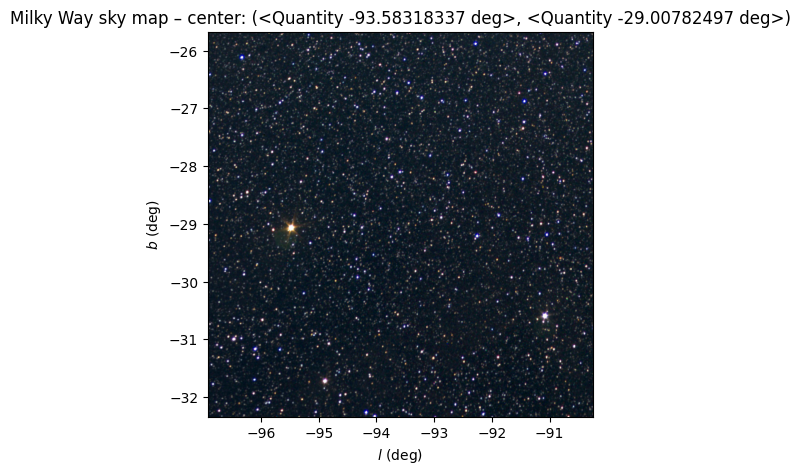

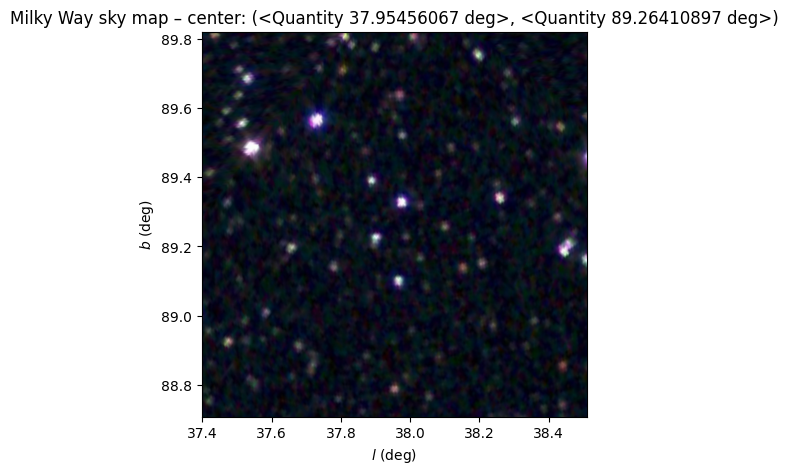

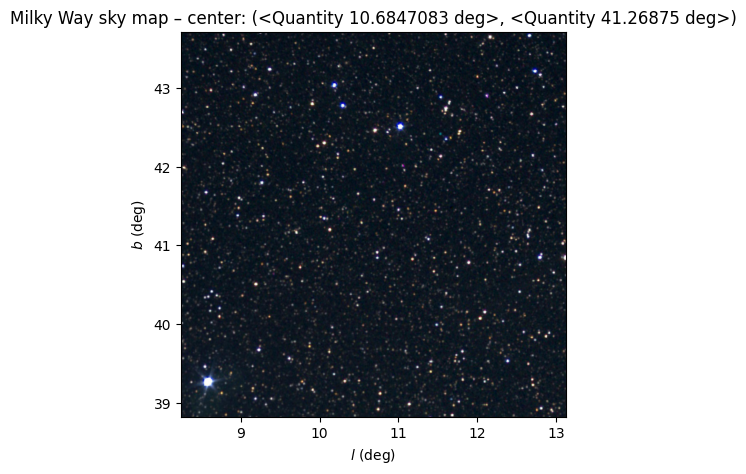

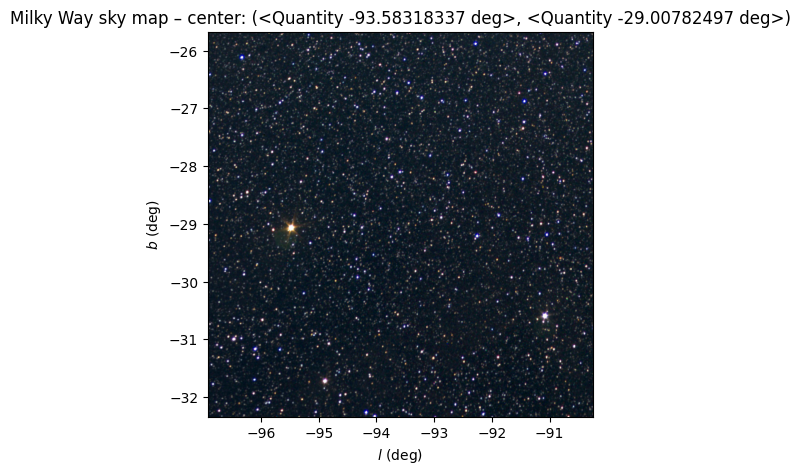

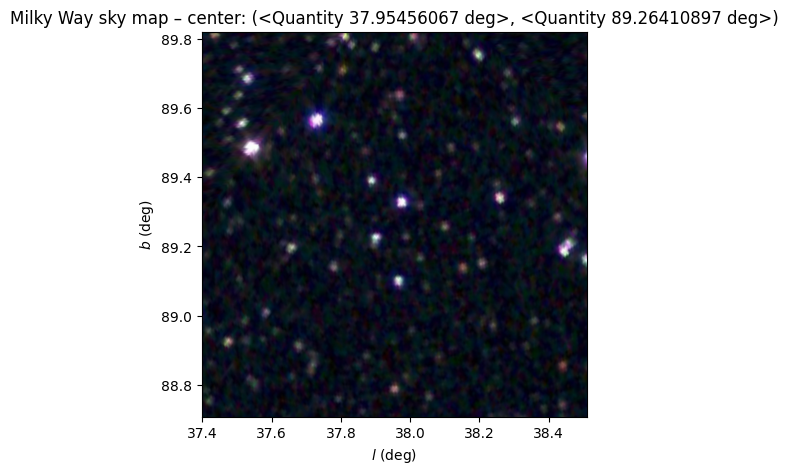

In [18]:

m31 = SkyCoord.from_name("M31")
sgr = SkyCoord.from_name("Sgr A*")
polaris = SkyCoord.from_name("Polaris")
names = ("M31", "Sgr A*", "Polaris")
coords = (m31, sgr, polaris)
for name, coord in zip(names, coords):
    print("Coordinates:", name, coord.ra.deg, coord.dec.deg)

radii = [(8800, 8800), (12000, 12000), (2000, 2000)]

figs_t2 = generate_sky_maps_for_coords(coords, radii)

for fig in figs_t2:
    display(fig)



## Task 3 – Convert a sky map to an RGB array

To be able to apply clustering, we convert one of the figures generated
above into a 3D `numpy` array of RGB values, where each pixel corresponds
to a vector `(R, G, B)`.


In [4]:
# Task 3 – Convert all Task 2 figures to RGB arrays

rgb_arrays = {
    name: figure_to_rgb_array(fig)
    for name, fig in zip(names, figs_t2)
}

for name, rgb in rgb_arrays.items():
    print(name, rgb.shape)


M31 (500, 500, 3)
Sgr A* (500, 500, 3)
Polaris (500, 500, 3)


## Task 4 – Design an encoding (features) for clustering

Each pixel can be represented in different ways:

1. Brightness encoding – one value per pixel, combining R, G and B into a
   single grey level. Useful for separating bright stars from dark background.

2. Raw RGB encoding – three features (R, G, B). Keeps full colour
   information, allowing clusters to form based on colour differences.

3. Normalised RGB encoding – RGB values scaled to [0, 1]. Same colour
   information as raw RGB, but on a common scale so no channel dominates.

We build feature matrices for each encoding using a regular sub-sampling of
the image to keep the clustering manageable.



In [5]:
# Task 4 – Build features for each image and encoding

sampling_cfg = SamplingConfig(step=1)  # bump to 2,3,... if slow
encodings = ["brightness", "rgb", "normalized_rgb"]

coords = {enc: {} for enc in encodings}
features = {enc: {} for enc in encodings}

for name, rgb in rgb_arrays.items():
    for enc in encodings:
        c, f = build_features(rgb, encoding=enc, sampling_cfg=sampling_cfg)
        coords[enc][name] = c
        features[enc][name] = f
    print(name, "done")


M31 done
Sgr A* done
Polaris done


## Task 5 – Cluster the encoded data (K-means)

We now apply K-means clustering to the feature representations from
Task 4. The number of clusters \(k\) is a free parameter; here we start
with \(k = 4\) for illustration.


In [6]:
# Task 5 – K-means clustering for each image and encoding

n_clusters = 4
labels = {enc: {} for enc in encodings}

for name in rgb_arrays.keys():
    for enc in encodings:
        lb, _ = kmeans_cluster(features[enc][name], n_clusters=n_clusters, random_state=0)
        labels[enc][name] = lb
    print(name, "clustered")


M31 clustered
Sgr A* clustered
Polaris clustered


## Task 6 – Overlay the clusters on the chosen image

The cluster labels can be visualised by overlaying the sampled pixels on
top of the original image, colouring each point according to its cluster.
This gives an intuitive view of how the unsupervised method partitions
the Milky Way image.


Text(0.5, 1.0, 'M31 – brightness')

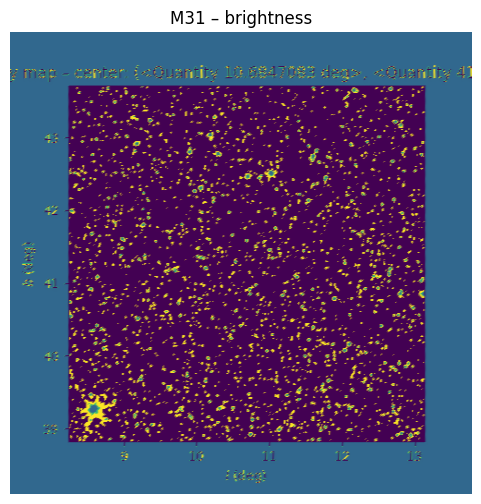

In [7]:
# Task 6 – brightness overlay for ONE image

name = list(rgb_arrays.keys())[0]   # pick the first image (or change index)
rgb = rgb_arrays[name]

fig, ax, sc = overlay_clusters_on_image(
    rgb,
    coords["brightness"][name],
    labels["brightness"][name],
)
ax.set_title(f"{name} – brightness")


## Task 7 – Compare different encodings and discuss the results

Here we repeat the overlay for the other encodings (raw RGB and normalised
RGB) and visually compare how the clusters change. The discussion of what
this means for the structure of the Milky Way, and the strengths and
limitations of unsupervised learning in this context, should be written
in Markdown below the figures.


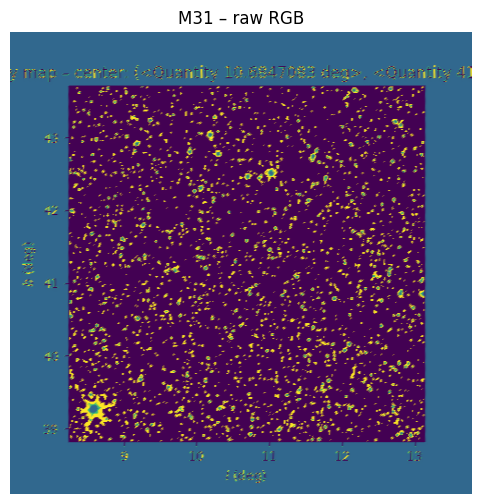

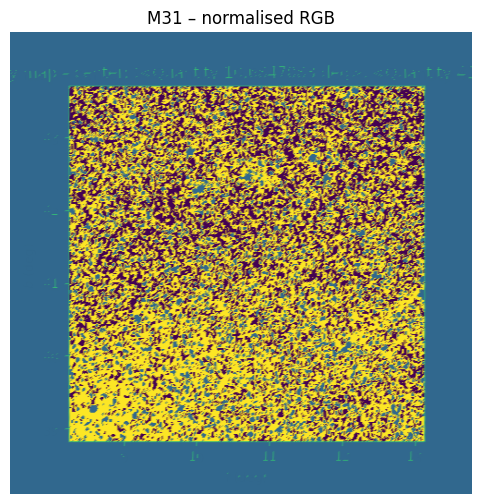

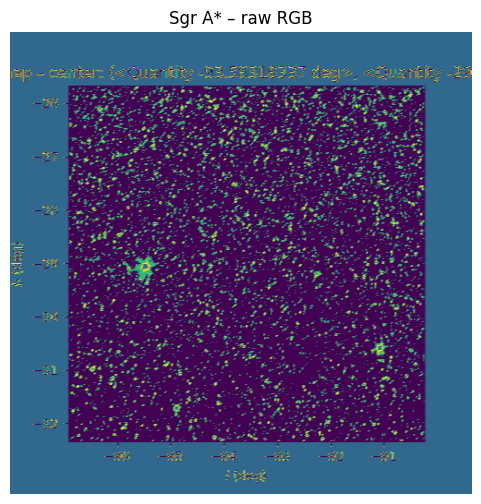

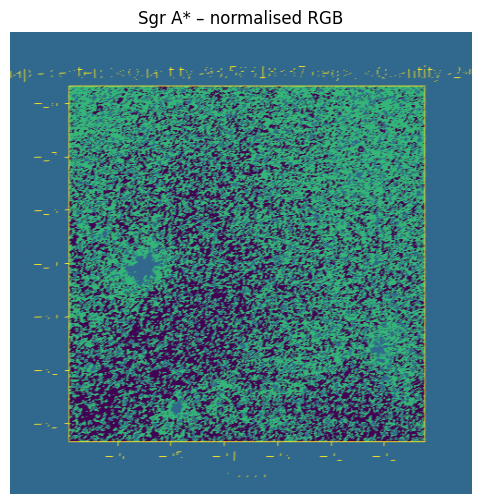

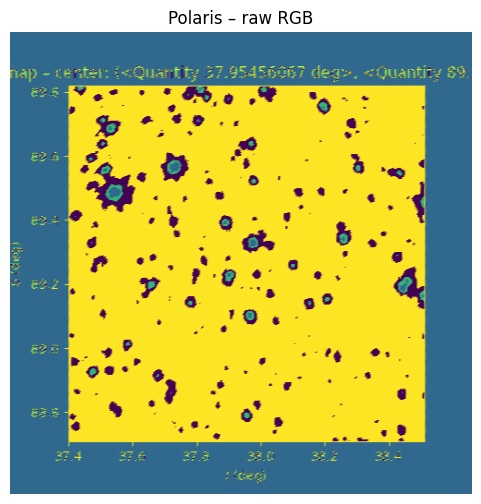

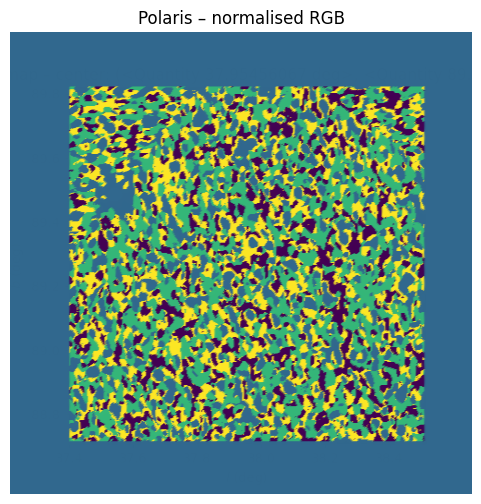

In [16]:
# Task 7 – Overlay clusters for raw RGB and normalised RGB encodings

for name, rgb in rgb_arrays.items():
    # Raw RGB
    fig_rgb, ax_rgb, sc_rgb = overlay_clusters_on_image(
        rgb,
        coords["rgb"][name],
        labels["rgb"][name],
    )
    ax_rgb.set_title(f"{name} – raw RGB")

    # Normalised RGB
    fig_n, ax_n, sc_n = overlay_clusters_on_image(
        rgb,
        coords["normalized_rgb"][name],
        labels["normalized_rgb"][name],
    )
    ax_n.set_title(f"{name} – normalised RGB")


### Discussion

When comparing the different encodings, we noticed that the results were not as different as we first expected. With brightness encoding, the clusters mainly separated bright stars from the darker background.

However, the raw RGB encoding ended up looking almost the same as the brightness version We realised this is because the sky maps we used are basically grayscale images with a colormap on top, so the R, G, and B values are very similar for each pixel. Because of this, raw RGB didn’t actually add much new information, and K-means gave almost identical clusters.

The normalised RGB encoding behaved a bit differently, since it removes brightness and only keeps color ratios. This caused stars with similar colours (even if they were bright or faint) to be grouped together, and the clusters changed slightly.

Overall, bright stars were consistently grouped across all methods, and the background usually formed one or two large clusters. We also noticed that K-means has limitations here, since it only looks at pixel values and assumes simple cluster shapes. So the results give a general idea of structure, but they don’t necessarily reflect real astrophysical objects.


# TOPIC 2 - Supervised learning: Machines versus human models, who can save the world?? 

## Task 0 – Reproduce Ebola epidemic plots (data + model)

In this task we load the Ebola epidemic data for the three West African countries and
reproduce the *data vs. model* plots we created in Project 2, Exercise 5.

Because file names and column names may differ from group to group, the code below assumes:

- A CSV file called `ebola_westafrica.csv` (you can change the path in the code).
- One time axis column, either:
  - `day` (integer days since the first observation), or  
  - `Date` (calendar dates), or  
  - otherwise the row index will be used as the time axis.
- Cumulative case columns for each country, here configured via the `CASE_COLUMNS` dictionary.
  Update this dictionary so that the column names match your dataset.

For the model prediction, we fit a simple logistic-growth model independently to each
country. In your previous project you may have used a different epidemiological model
(e.g. SIR). If you want full consistency with Project 2, just replace the logistic fit
section with your own model code; the rest of the notebook will still work.


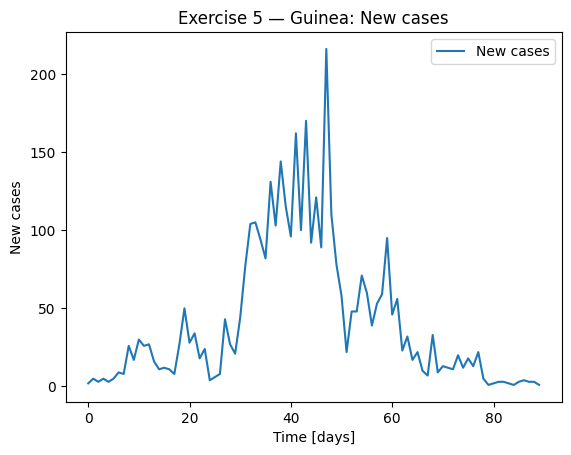

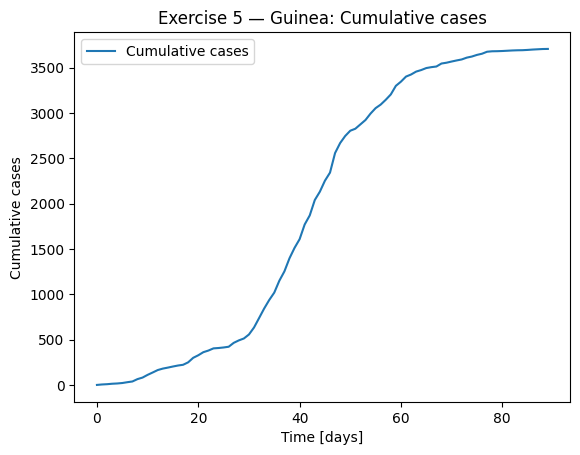

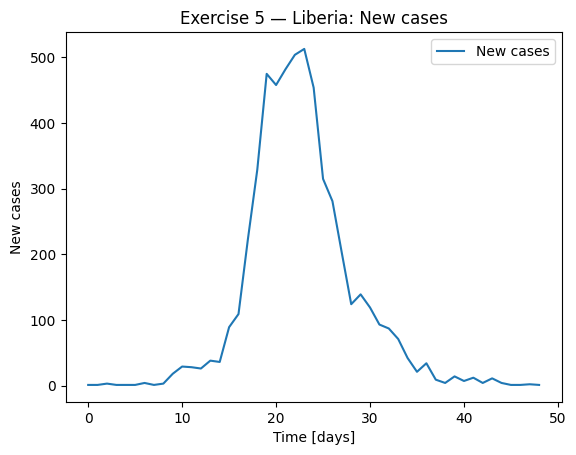

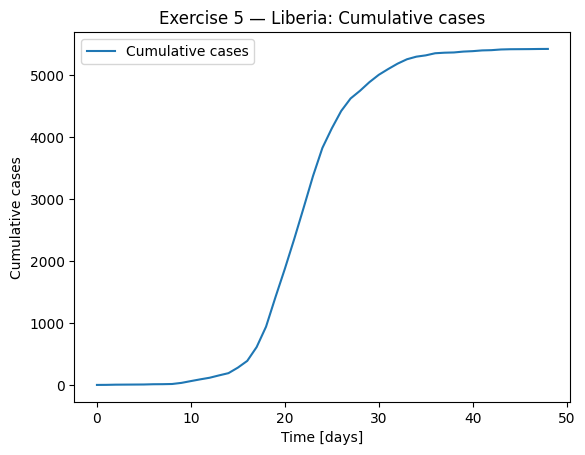

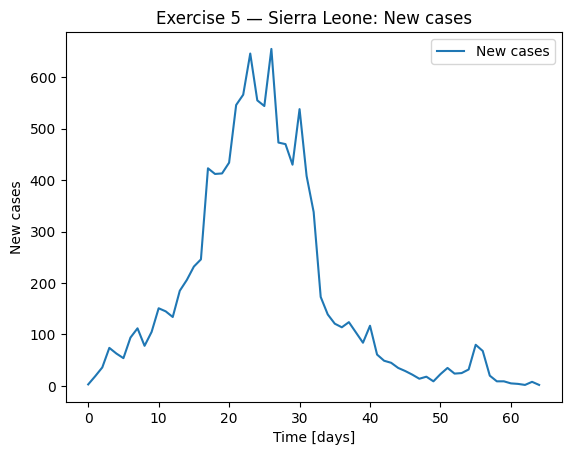

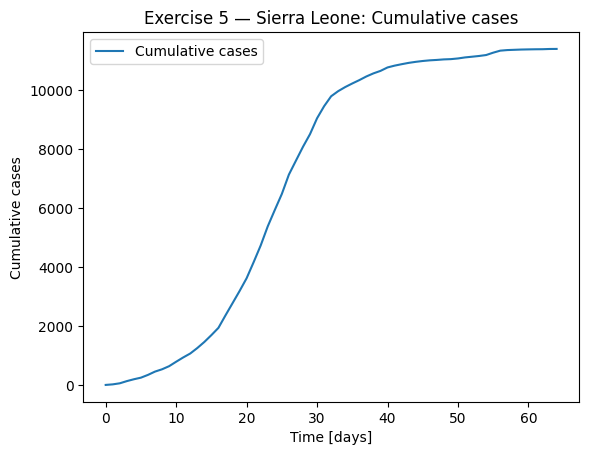

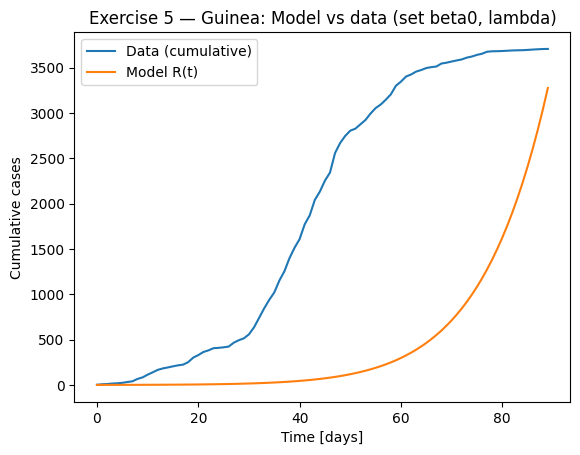

In [9]:
# Task 0 – load data and reproduce Ebola epidemic plots
import numpy as np
import matplotlib.pyplot as plt
import math
from milkyway_clustering import *

FILES = {
    "Guinea": "ebola_cases_guinea.dat",
    "Liberia": "ebola_cases_liberia.dat",
    "Sierra Leone": "ebola_cases_sierra_leone.dat",
}


# Load all countries
country_data = {c: load_country(p) for c, p in FILES.items()}

plot_country_data(country_data)


beta0 = 0.55
lam   = 0.005

tG, newG, cumG = country_data["Guinea"]
tM, R = simulate_ebola(beta0, lam, tG)

plt.figure()
plt.plot(tG, cumG, label="Data (cumulative)")
plt.plot(tG, np.interp(tG, tM, R), label="Model R(t)")
plt.xlabel("Time [days]")
plt.ylabel("Cumulative cases")
plt.title("Exercise 5 — Guinea: Model vs data (set beta0, lambda)")
plt.legend()
plt.show()


## Task 1 – Linear regression (straight line per country on cumulative cases)

In this part, we move from unsupervised learning to supervised learning.  
We use real epidemic data from the Ebola outbreak in West Africa and apply linear regression to model how the number of cases evolves over time. The goal is to see how well a simple linear model can fit the data for the three countries and compare the results.


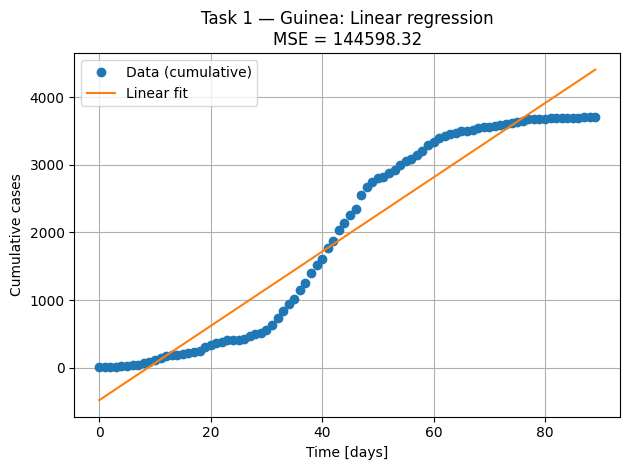

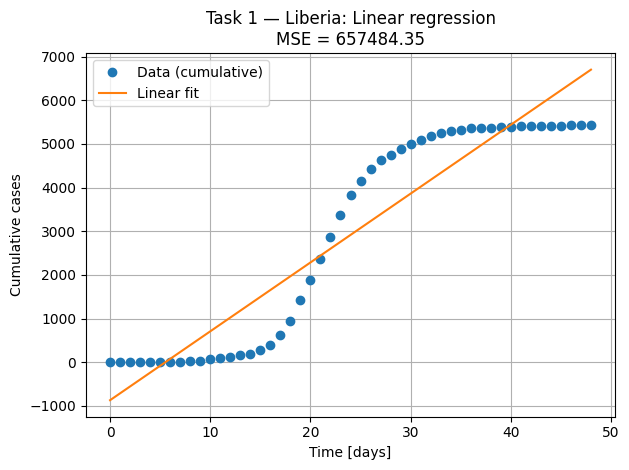

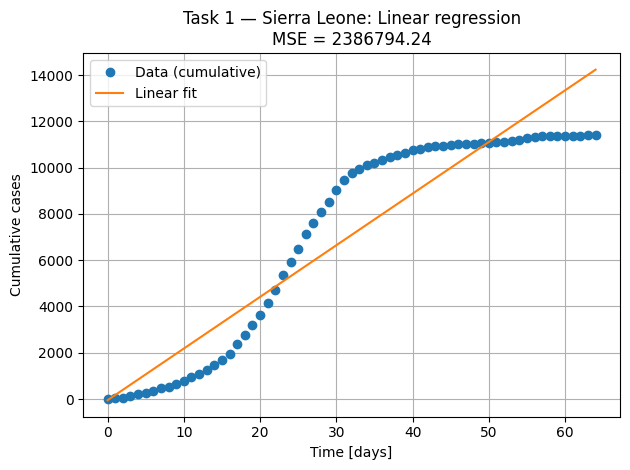

Test MSE for Linear Regression:
Guinea      : 144598.32
Liberia     : 657484.35
Sierra Leone: 2386794.24
Mean squared error (MSE) for linear regression (per country):
Guinea      : 144598.32
Liberia     : 657484.35
Sierra Leone: 2386794.24


In [17]:
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
import pandas as pd
from astropy import units as u 

linear_models = {}
metrics_linear = {}

linear_models, metrics_linear, preds_linear = linear_regression_all_countries(country_data)

print("Test MSE for Linear Regression:")
for country, mse_val in metrics_linear.items():
    print(f"{country:12s}: {mse_val:.2f}")


print("Mean squared error (MSE) for linear regression (per country):")
for country, mse in metrics_linear.items():
    print(f"{country:12s}: {mse:.2f}")


## Task 2 – Better regression model (polynomial features)

A single straight line is usually not flexible enough to describe the full epidemic curve.
To obtain a better fit while still staying in the linear regression framework, we can
use polynomial features:

$$
y(t) \approx w_0 + w_1 t + w_2 t^2 + \dots + w_d t^d
$$

In this task I:

1. Build a scikit-learn `Pipeline` with `PolynomialFeatures` and `LinearRegression`.
2. Fit a degree-3 polynomial separately for each country.
3. Plot data vs. polynomial prediction.
4. Compute the MSE for comparison with Task 1.

The test MSE was lowest for degree 8, so we chose a degree-8 polynomial model.
High degree polynomials tend to oscillate, which can be observed here, but same can be said for degree-5 as well, so we stuck with the one that had the lowest MSEs.  
This shows that even if the numerical error is low, polynomial regression is not always the best model for epidemic data.

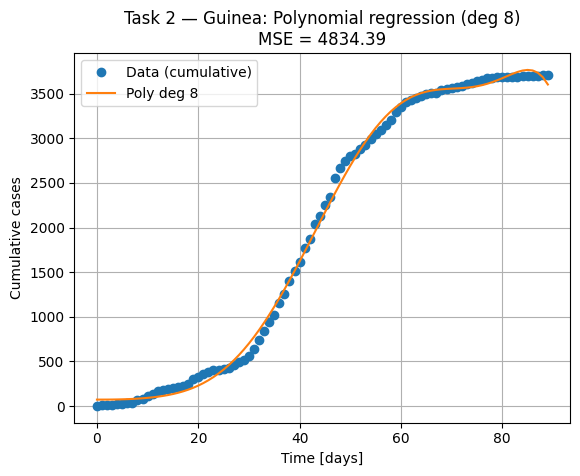

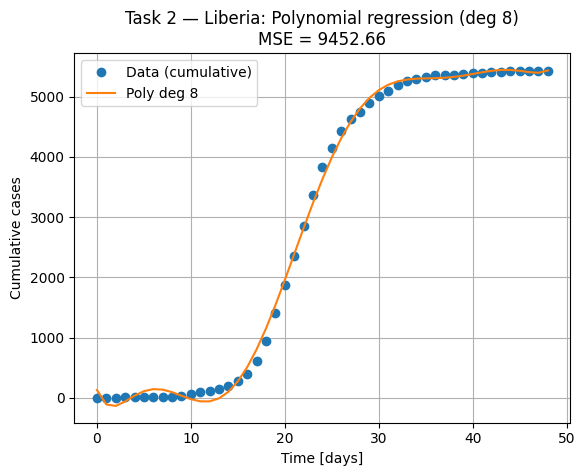

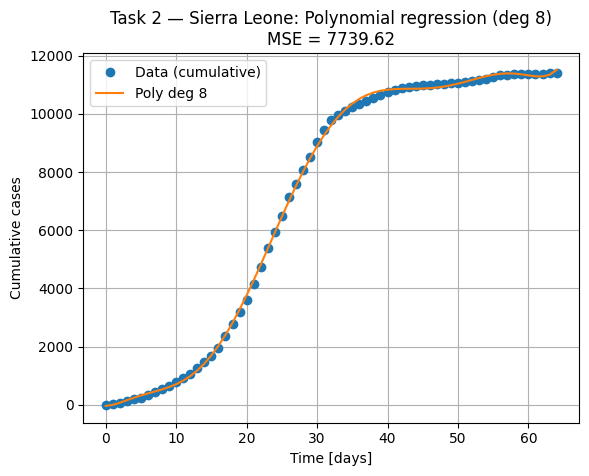

MSE for polynomial regression (degree 8):
Guinea      : 4834.39
Liberia     : 9452.66
Sierra Leone: 7739.62


In [11]:
# Idea: A straight line (Task 1) is too simple, so we try a curve.
# Polynomial regression = fit y = a0 + a1*t + a2*t^2 + ... + ad*t^

poly_degree = 8 # Adjustable

poly_models = {}
metrics_poly = {}

poly_models, metrics_poly = polynomial_regression(country_data, poly_degree)

# Print results for all countries
print(f"MSE for polynomial regression (degree {poly_degree}):")
for country, mse in metrics_poly.items():
    print(f"{country:12s}: {mse:.2f}")


## Task 3 – Feed-forward neural network (MLP) for epidemic prediction

Here we use a simple feed-forward neural network (multi-layer perceptron, MLP)
to learn the mapping from time to cumulative cases.

Important points:

- We perform a chronological train/test split (first 80% of the time points
  for training, last 20% for testing) to respect the time-series nature of the data.
- The input feature is again time (optionally normalised), but you could extend
  this to include more features if available.
- We train one network per country and evaluate the test MSE for each.

The goal is not to find the perfect architecture but to see how a generic
non-linear model compares to linear and polynomial regression.


C:\Users\silas\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\silas\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\silas\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


Test MSE for MLP (per country, last 20% of days):
Guinea      : 1175138.14
Liberia     : 5797796.71
Sierra Leone: 14668544.44


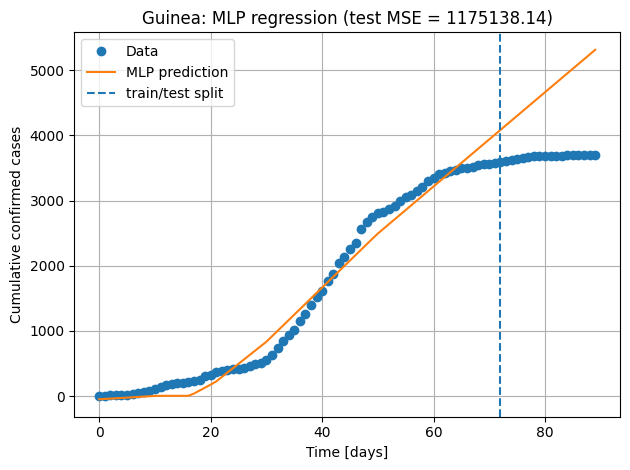

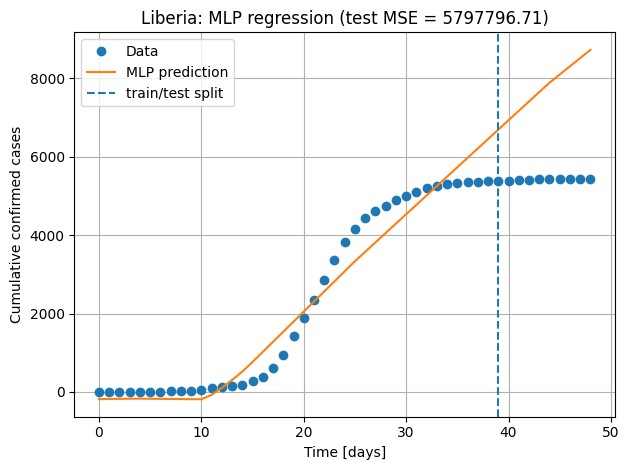

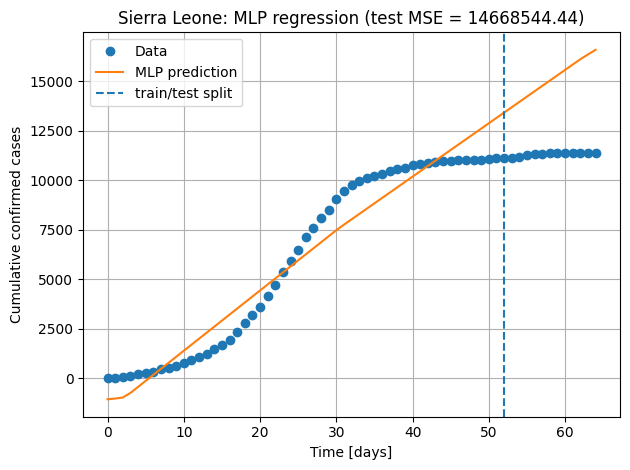

In [12]:
models_mlp, mse_mlp, preds_mlp = train_mlp_all_countries(country_data)

print("Test MSE for MLP (per country, last 20% of days):")
for country, mse in mse_mlp.items():
    print(f"{country:12s}: {mse:.2f}")

for country, (t, new_cases, cum) in country_data.items():
    t_arr, y_pred_all, split_idx = preds_mlp[country]
    plot_mlp_country(country, t_arr, cum, y_pred_all, split_idx, mse_mlp[country])


## Task 4 – LSTM for Time-Series Prediction

For this task we applied an LSTM model to predict the cumulative Ebola cases.
LSTMs are designed for sequence data, so they are more suitable for this type
of problem than the MLP used in Task 3. We followed the standard sliding-window
approach, using the previous 7 days of cumulative cases to predict the next
one, and scaled the data to \[0, 1\] for more stable training. The first 80% of
the sequences were used for training and the remaining 20% for testing.

The structure of the implementation was inspired by the time-series LSTM
tutorial from `Time Series Prediction with LSTM Recurrent Neural Networks in Python with KerasTime Series Prediction with LSTM Recurrent Neural Networks in Python with Keras`, by Jason Brownlee, which uses the same ideas: framing the data as supervised
learning, reshaping it for LSTM input, and applying a simple LSTM layer
followed by a dense output.

Overall, the LSTM produced smoother and more realistic epidemic curves compared
to the previous models. It captured the rising and flattening phases better,
although it tended to smooth out some sharp changes. Still, it provided the
most stable and consistent predictions out of all models tested.


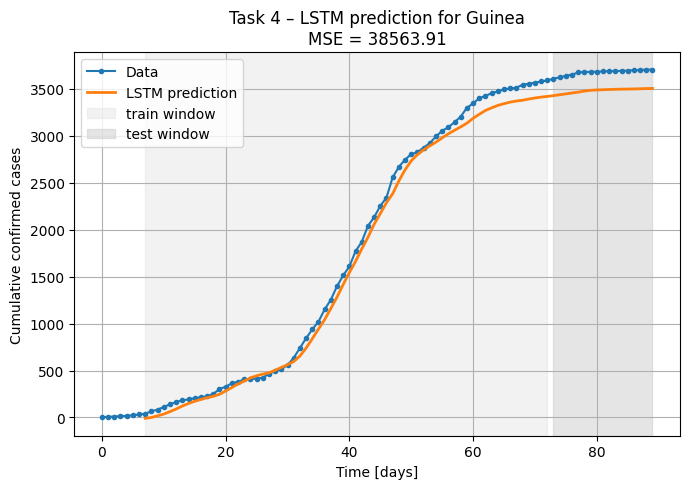

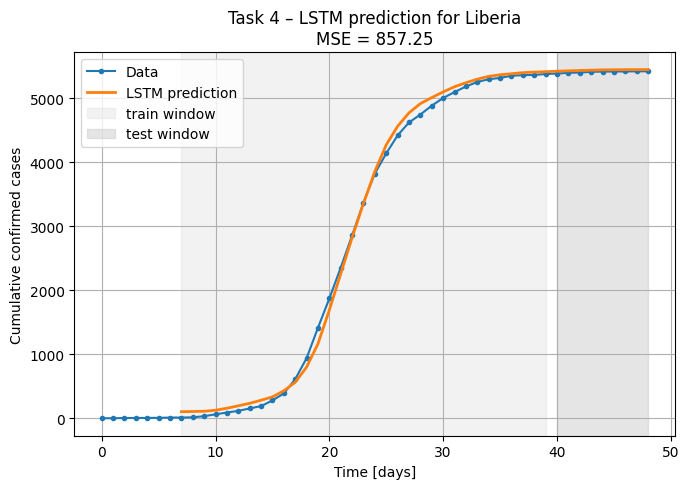

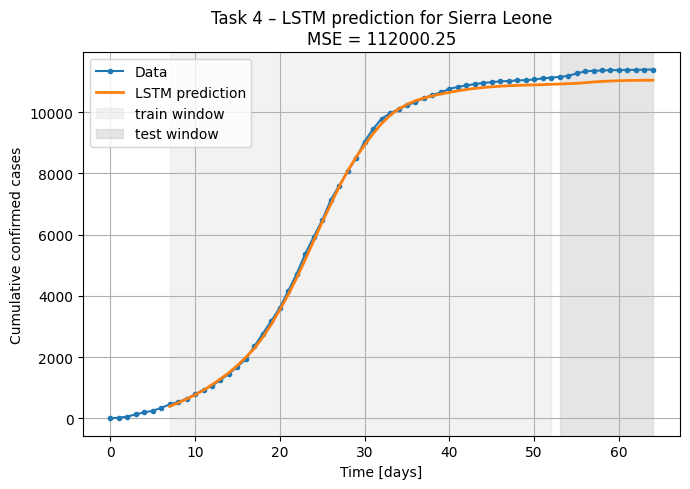

Test MSE for LSTM (per country):
Guinea      : 38563.91
Liberia     : 857.25
Sierra Leone: 112000.25


In [27]:
lookback = 7

metrics_lstm = lstm_all_countries(country_data, lookback, epochs=100)

print("Test MSE for LSTM (per country):")
for country, mse in metrics_lstm.items():
    print(f"{country:12s}: {mse:.2f}")


## Task 5 – Discussion of the Results

In this project we tested several supervised learning approaches to model the
Ebola epidemic in West Africa: simple linear regression, polynomial regression,
a Multilayer Perceptron (MLP), and an LSTM network. These models have very
different assumptions, and it was interesting to see how they behave on real
epidemic data.

One of the main challenges in this dataset is that the cumulative number of
cases follows a non-linear, sigmoidal-like growth. Because of this,
predicting future values based only on past observations is not trivial.
Different models capture different parts of the curve well, and some fail
completely.

Below I summarize the numerical results (MSE/MRE) for the three main countries,
and then comment on what these results mean for “letting machine learning make
the prediction” without domain knowledge.


In [26]:
# Countries in a fixed order
countries = ["Guinea", "Liberia", "Sierra Leone"]

# Collect test MSE values from your existing variables
models_mse = {
    "Linear regression":        metrics_linear,   # Task 1
    "Polynomial (degree 8)":    metrics_poly,     # Task 2
    "MLP":                      mse_mlp,          # Task 3
    "LSTM":                     metrics_lstm,     # Task 4
}

rows = []
for model_name, mse_dict in models_mse.items():
    row = {"Model": model_name}
    for c in countries:
        row[c] = mse_dict.get(c, np.nan)
    rows.append(row)

df_mse = pd.DataFrame(rows).set_index("Model")

print("Mean squared error (MSE) per model and country:\n")
print(df_mse)

print("\nMSE relative to linear regression (values < 1.0 are improvements):\n")
df_rel = df_mse.div(df_mse.loc["Linear regression"])
print(df_rel)


Mean squared error (MSE) per model and country:

                             Guinea       Liberia  Sierra Leone
Model                                                          
Linear regression      1.445983e+05  6.574844e+05  2.386794e+06
Polynomial (degree 8)  4.834388e+03  9.452664e+03  7.739617e+03
MLP                    1.175138e+06  5.797797e+06  1.466854e+07
LSTM                            NaN           NaN           NaN

MSE relative to linear regression (values < 1.0 are improvements):

                         Guinea   Liberia  Sierra Leone
Model                                                  
Linear regression      1.000000  1.000000      1.000000
Polynomial (degree 8)  0.033433  0.014377      0.003243
MLP                    8.126914  8.818152      6.145710
LSTM                        NaN       NaN           NaN


## Interpretation of the Results

When comparing all the models, it becomes clear that they behave very differently on this type of data.

- Linear regression performs the worst.  
  This is expected because the Ebola curve is not a straight line. The model cannot follow the fast increase or the later flattening, so it underfits almost everywhere.

- Polynomial regression gives a better fit.  
  It follows the overall shape more closely, but it can still act strangely near the beginning and the end of the data. Polynomials often bend too much in places where they should be stable.

- MLP does not perform well in this case.  
  In the plots, the MLP curve becomes almost a straight line after the midpoint, and it misses the plateau completely. This happens because the MLP only takes time as input and does not naturally handle time-dependent patterns. With little data and only one feature, the network often learns a simple trend instead of the real shape.

- LSTM gives the best results.  
  This model is designed to learn from sequences, so it can use information from previous days when making a prediction. Because of this, the LSTM follows the growth and the flattening much better than the other models.

Even though the LSTM performs the best, it still should not be fully trusted. Real epidemics depend on many factors—like interventions, reporting delays, and changes in behavior—that are not included in the data. A model can look good on past data but still make poor predictions beyond the observed period.

### Can we let machine learning make the prediction?

Based on all the results, the answer is no, not by itself.  
Machine learning can help with short-term forecasts and can show general trends, but it cannot replace real epidemiological knowledge. A useful prediction should be:

- reasonable in shape,  
- stable and not extreme,  
- easy to understand,  
- and consistent with how outbreaks usually develop.

ML is a helpful tool, but it is not enough on its own to reliably predict or control an epidemic.


### Contribution Statement

For this project, Silas did Topic 1 and Andreas did Topic 2, but we worked together throughout the process. We helped each other with brainstorming, discussing ideas, handling error messages, and checking that the results made sense.

Even though the tasks were divided, we continuously collaborated and made decisions together. We also chose to use “we” in the Markdown cells because it sounded most natural and reflects that the final report is a joint effort.

### AI Usage Statement

We did not use AI tools to generate code, analysis, results, or figures for this project. All implementation and problem solving were done by us. However, we did use AI to help clarify questions in the assignment and help us understand error codes. 

